In [1]:
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [2]:
# Set base directories for training and testing
train_base_dir = Path("D:/OneDrive/Desktop/Training") # Replace with the actual training folder path
test_base_dir = Path("D:/OneDrive/Desktop/Testing")    # Replace with the actual testing folder path  

In [3]:
# Define parameters
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 30

In [4]:
# Classes
CLASSES = ['glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor']

In [5]:
# Helper function to load images from a directory
def load_images_from_directory(directory, image_size):
    data = []
    labels = []
    for idx, class_name in enumerate(CLASSES):
        class_dir = directory / class_name
        for img_file in os.listdir(class_dir):
            img_path = class_dir / img_file
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  
            data.append(img_array)
            labels.append(idx)
    return np.array(data), np.array(labels)

In [6]:
# Load training and testing data
x_train, y_train = load_images_from_directory(train_base_dir, IMAGE_SIZE)
x_test, y_test = load_images_from_directory(test_base_dir, IMAGE_SIZE)

In [8]:
# Function to load and display a single image from the training dataset
def load_and_display_image(class_name, image_index, image_size):
    class_dir = train_base_dir / class_name
    img_file = os.listdir(class_dir)[image_index]  
    img_path = class_dir / img_file
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  

    plt.imshow(img)
    plt.title(f"Class: {class_name} - Image: {img_file}")
    plt.axis('off')
    plt.show()

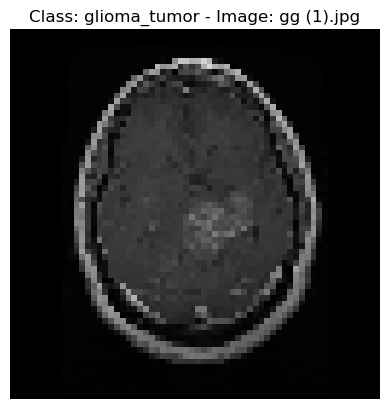

In [9]:
# Example of loading and displaying an image from the "glioma_tumor" class
load_and_display_image('glioma_tumor', 0, IMAGE_SIZE) 

In [10]:
# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=len(CLASSES))
y_test = to_categorical(y_test, num_classes=len(CLASSES))


In [11]:
# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE)


In [12]:
# Load pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

In [13]:
# Freeze the layers in VGG16
for layer in vgg16.layers:
    layer.trainable = False

In [14]:
# Add custom layers
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = Dense(len(CLASSES), activation='softmax')(x)


In [15]:
# Define the model
model = Model(inputs=vgg16.input, outputs=x)

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=(x_test, y_test), batch_size=BATCH_SIZE)

Epoch 1/30
90/90 [==============================] - 50s 492ms/step - loss: 1.0218 - accuracy: 0.5564 - val_loss: 1.7508 - val_accuracy: 0.3985
Epoch 2/30
90/90 [==============================] - 37s 411ms/step - loss: 0.7965 - accuracy: 0.6686 - val_loss: 1.6281 - val_accuracy: 0.4975
Epoch 3/30
90/90 [==============================] - 37s 412ms/step - loss: 0.7280 - accuracy: 0.6944 - val_loss: 1.7745 - val_accuracy: 0.4289
Epoch 4/30
90/90 [==============================] - 38s 419ms/step - loss: 0.7212 - accuracy: 0.6986 - val_loss: 1.5240 - val_accuracy: 0.5203
Epoch 5/30
90/90 [==============================] - 38s 426ms/step - loss: 0.6883 - accuracy: 0.7247 - val_loss: 1.4758 - val_accuracy: 0.5381
Epoch 6/30
90/90 [==============================] - 41s 452ms/step - loss: 0.6552 - accuracy: 0.7341 - val_loss: 1.5689 - val_accuracy: 0.5685
Epoch 7/30
90/90 [==============================] - 39s 436ms/step - loss: 0.6460 - accuracy: 0.7446 - val_loss: 1.6900 - val_accuracy: 0.5152

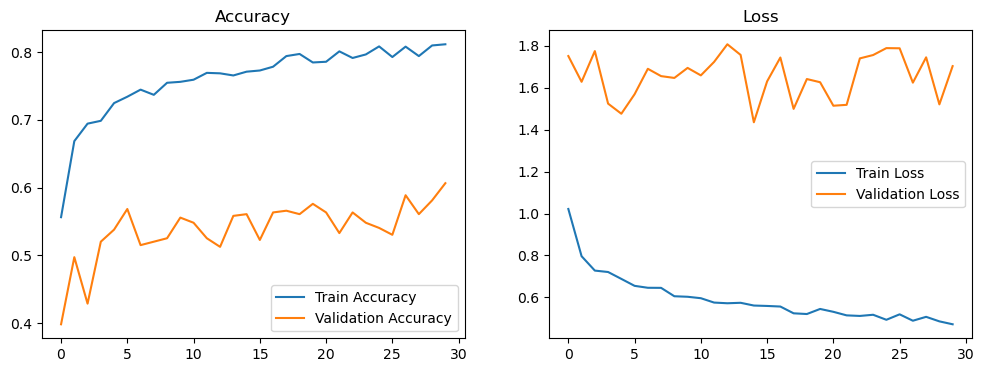

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

13/13 [==============================] - 4s 265ms/step


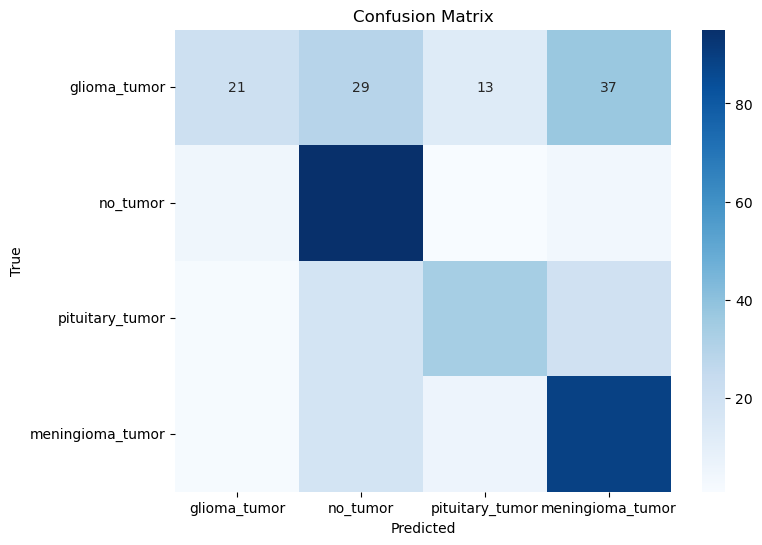

In [19]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# Import necessary libraries
from sklearn.metrics import classification_report, roc_auc_score

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

# ROC-AUC Score (One-vs-Rest for multi-class classification)
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.70      0.21      0.32       100
        no_tumor       0.59      0.90      0.72       105
 pituitary_tumor       0.63      0.46      0.53        74
meningioma_tumor       0.59      0.77      0.67       115

        accuracy                           0.61       394
       macro avg       0.63      0.59      0.56       394
    weighted avg       0.63      0.61      0.57       394

ROC-AUC Score: 0.8052


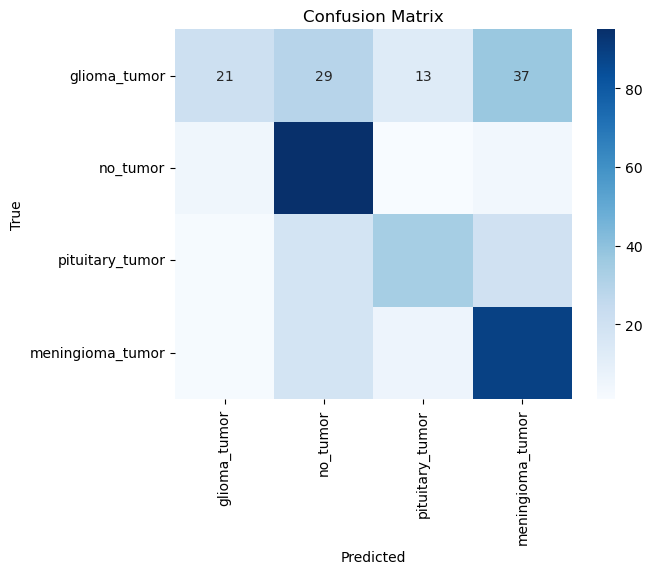

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [24]:
###

In [28]:
###

In [24]:
# Save the trained model to a file
model.save('bt.h5')  # Replace 'your_model_path.h5' with your desired model file path


13/13 [==============================] - 3s 265ms/step


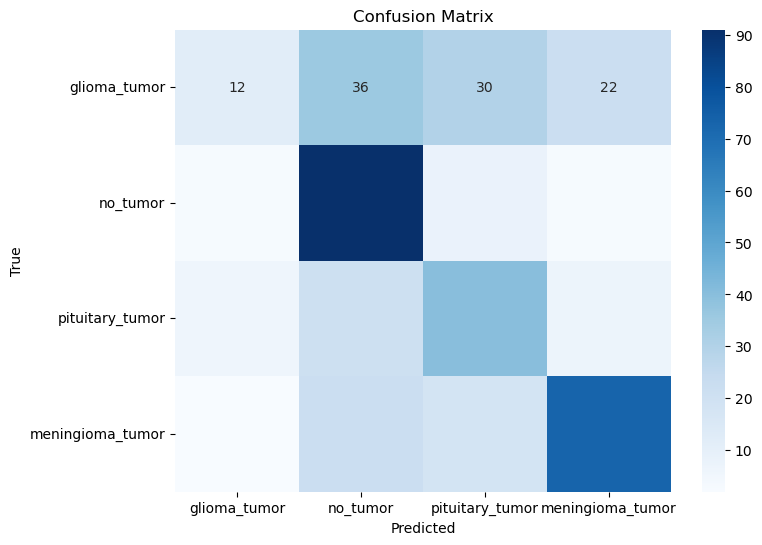

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
